# Задание 3. Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [61]:
import numpy as np
import matplotlib.pyplot as plt

D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

In [62]:
X.shape

(1000, 4)

In [63]:
import seaborn as sns
import pandas as pd

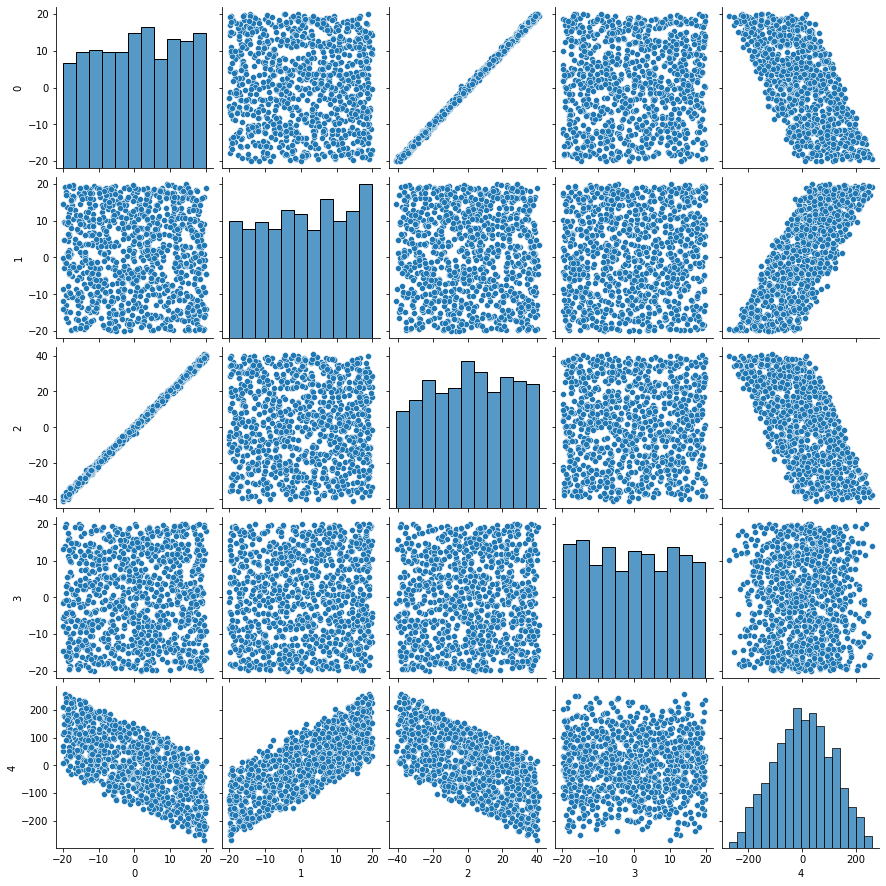

In [64]:
sns.pairplot(pd.DataFrame(D))

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [88]:
class LinearRegressor():
    def __init__(self, learning_rate=0.0001, l1_coef=0, l2_coef=0, verbose = False):
        #self.w = np.random.normal(loc=1, scale=1, size=(5, 1))
        self.w = None
        self.learning_rate = learning_rate
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.fitted = False
        self.history_loss = []
        self.history_w = []
        self.verbose = verbose

    def fit(self, X, y, n_iter=100, analytic = False):
        X_train = np.hstack((X,np.ones((X.shape[0], 1))))
        self.fitted = True
        eps = 1e-5
        if analytic:
            X1 = X_train.T.dot(X_train)
            X_inv = np.linalg.inv(X1)
            res = X_inv.dot(X_train.T).dot(y)
            print("loss = ", LinearRegressor.mse(X_train.dot(res), y))
            self.w = res
            return


        n, m = X_train.shape
        steps = 0

        y = np.reshape(y, (max(y.shape), 1))
        self.w = np.ones((X_train.shape[1],1))
        loss = 1

        while steps < n_iter and not np.isclose(loss, 0):

            y_pred = self.predict(X_train[:,:-1])

            y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))

            self.last_pred = y_pred

            loss = LinearRegressor.mse(y, y_pred)

            self.history_loss.append(loss)

            grad_w = (X_train.T + self.l1_coef * LinearRegressor.l2_reg_grad(self.w) + \
                        self.l2_coef * LinearRegressor.l1_reg_grad(self.w)).\
                        dot(2*(y_pred - y))

            self.w -= self.learning_rate * grad_w / n
            self.history_w.append(self.w)
            if (grad_w**2).mean() < eps:
                break

            steps += 1
            print(f"loss on {steps} step =  ", loss) if self.verbose else None

    def predict(self, X):
        if not self.fitted:
            raise ValueError("Model is not fitted")
        X_train = np.hstack((X,np.ones((X.shape[0], 1))))
        n, m = X_train.shape
        y_pred = X_train.dot(self.w) # + self.l2_coef * LinearRegressor.l2_reg(self.w) + self.l1_coef * LinearRegressor.l2_reg(self.w)
        return np.reshape(y_pred, (y_pred.shape[0]))


    @staticmethod
    def l2_reg(w):
        return 1 / (w.shape[0]) * np.sum(w**2)

    @staticmethod
    def l2_reg_grad(w):
        return 2 / (w.shape[0]) * w
    
    @staticmethod
    def l1_reg(w):
        return 1 / (w.shape[0]) * np.sum(np.abs(w))

    @staticmethod
    def l1_reg_grad(w):
        return 1 / (w.shape[0]) * np.sign(w)

    @staticmethod
    def mse(y_true, y_pred):
        return ((y_pred - y_true)**2).mean()

In [89]:
X_train, X_test = X[ : 800, :], X[800 : , :]
y_train, y_test = Y[ : 800], Y[800 :]

lr_analytic = LinearRegressor()
lr_analytic.fit(X_train, y_train, analytic=True)
print(LinearRegressor.mse(y_train, lr_analytic.predict(X_train)))
print(LinearRegressor.mse(y_test, lr_analytic.predict(X_test)))

loss =  93.49583512119891
93.49583512119891
101.00939346587472


For l2_coef 0.1 mse = 118.44574171920641 (1000,)
For l2_coef 0.2 mse = 118.43917889819433 (1000,)
For l2_coef 0.30000000000000004 mse = 118.4326296361628 (1000,)
For l2_coef 0.4 mse = 118.42609391044024 (1000,)
For l2_coef 0.5 mse = 118.4195716983937 (1000,)
For l2_coef 0.6000000000000001 mse = 118.41306297742814 (1000,)
For l2_coef 0.7000000000000001 mse = 118.40656772498787 (1000,)
For l2_coef 0.8 mse = 118.40008591855498 (1000,)
For l2_coef 0.9 mse = 118.39361753565063 (1000,)


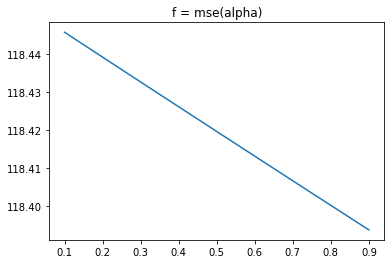

In [90]:
alphas = [0.1*x for x in range(1, 10)]
mses = []
for alpha in alphas:
    lr_grad_descent = LinearRegressor(l2_coef=alpha)
    lr_grad_descent.fit(X, Y)
    mse = LinearRegressor.mse(Y, lr_grad_descent.predict(X))
    print(f"For l2_coef {alpha} mse = {mse}", Y.shape)
    mses.append(mse)

plt.title("f = mse(alpha)")
plt.plot(alphas, mses)


In [95]:
val_score = []
train_score = []
step = 0
aphas = [0.1*x for x in range(1, 10)]
models = []
for alpha in aphas:
    X_train = np.vstack((X[i::5, :] for i in range(5) if i != step))
    X_val = X[step::5, :]
    y_train = np.hstack((Y[i::5] for i in range(5) if i != step))
    y_val = Y[step::5]

    lr = LinearRegressor(l2_coef=alpha)
    lr.fit(X_train, y_train)
    models.append(lr)
    y_pred = lr.predict(X_val)
    val_score.append(LinearRegressor.mse(y_val, y_pred))
    train_score.append(LinearRegressor.mse(y_train, lr.predict(X_train)))
    step += 1

C:\Users\f17o0\AppData\Local\Temp/ipykernel_22132/2812438777.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_train = np.vstack((X[i::5, :] for i in range(5) if i != step))
C:\Users\f17o0\AppData\Local\Temp/ipykernel_22132/2812438777.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_train = np.hstack((Y[i::5] for i in range(5) if i != step))


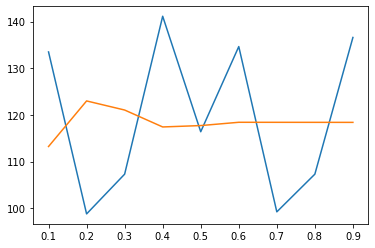

In [96]:
plt.plot(aphas, val_score)
plt.plot(aphas, train_score)
plt.show()

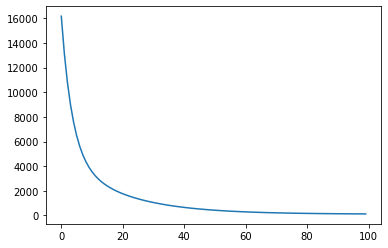

In [93]:
best_model = models[np.argmin(val_score)]

plt.plot(range(len(best_model.history_loss)), best_model.history_loss)
plt.show()